In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import run
import measure

import pickle
from scipy import stats
import numpy as np
import pandas as pd
import glob

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

#Supress default INFO logging

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

import sys
sys.path.append('../../')
sys.path.append('../')


import german.default as german_default
import german.questions as german_questions
import german.parameters as german_parameters
import german.valid as german_valid

import ipums.default as ipums_default
import ipums.valid as ipums_valid
import ipums.questions as ipums_questions
import ipums.parameters as ipums_parameters

In [23]:
sns.set(style='whitegrid', font_scale=1.5)

In [5]:
df = []

for default, dataset, qprefix, questions in zip(
    [ipums_default.default, german_default.default], 
    ['IPUMS', 'German'],
    ['I', 'G'],
    [ipums_valid.questions, german_valid.questions],
):
    for i, question in enumerate(questions):
        controls = []
        for rho in [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10]:
            controls.append(question + 
                [
                    ('k', -1), ('rho_topk', rho), ('topk_only', True)
                ]
            )
        default = {**run.DEFAULT, **default} 
        for setting_change in controls:
            setting = default.copy()
            for key, value in setting_change: 
                setting[key] = value
            hashed = run.hash_setting(setting)
            fprefix = f'./intermediates/{hashed}'
            tau_list = []
            k = None
            for fname in glob.glob(fprefix + '*'):
                with open(fname, 'rb') as finp:
                    intermediates = pickle.load(finp)
                noisy_topk = intermediates['Topk']
                true_topk = measure.get_sorted_predicates(intermediates)
                noisy_index = [true_topk.tolist().index(p) for p in noisy_topk]
                tau, p_value = stats.kendalltau(noisy_index, np.arange(len(true_topk)))
                tau_list.append(tau)
                k = len(intermediates['InfluScores'])
            tau = np.mean(tau_list)
            df.append({
                'Question': f'{qprefix}{i+1}',
                'Privacy Budget of Topk': setting['rho_topk'],
                'Predicate Size l': setting['predicate_strategy'],
                'Explanation Size k': k,
                'Kendall-Tau': tau,
            })
df = pd.DataFrame(df)

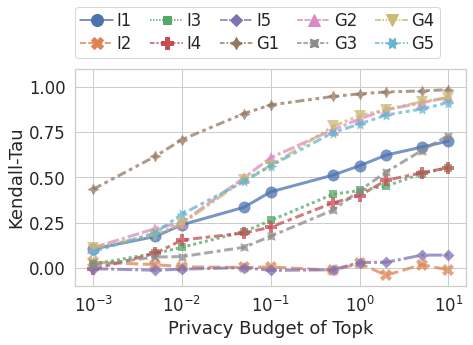

In [37]:
fig, ax = plt.subplots(figsize=(7,4))
sns.lineplot(data=df, 
             x='Privacy Budget of Topk', y='Kendall-Tau', 
             hue='Question', 
             style='Question', 
             lw = 3,
             ax = ax,
             alpha = 0.75,
             markersize = 12,
             markeredgewidth = 0,
             markers=True, 
             dashes=True)
ax.legend(ncol=5, loc=(-0, 1.05),
          markerscale=2, 
          borderpad = 0.3,
          handletextpad=0.2,
          labelspacing=0.3,
          columnspacing=1.1)
ax.set_xscale('log')
ax.set_ylim(-0.1, 1.1)
fig.savefig(f'./plots/KendallTau-budget.pdf', bbox_inches='tight')

In [21]:
for idx, row in df.query('`Privacy Budget of Topk` == 10')[['Kendall-Tau', 'Question']].iterrows():
    print(f"{row['Question']} is {row['Kendall-Tau']:.2f},")

I1 is 0.70,
I2 is -0.01,
I3 is 0.55,
I4 is 0.55,
I5 is 0.07,
G1 is 0.98,
G2 is 0.94,
G3 is 0.73,
G4 is 0.94,
G5 is 0.91,
